In [1]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

In [1]:
import numpy as np
import array
import math
import random

random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import warnings

warnings.filterwarnings("ignore")

from dtaidistance import (
    ed as dtai_ed,
    dtw as dtai_dtw,
    dtw_visualisation as dtai_dtw_visualisation,
)
from aeon.distances import (
    euclidean_distance as aeon_euclidean_distance,
    dtw_distance as aeon_dtw_distance,
)
from sktime.distances import dtw_distance as sktime_dtw_distance

from pyts.metrics import dtw as pyts_dtw

from tslearn.metrics import dtw as tslearn_dtw, dtw_path as tslearn_dtw_path

In [3]:
%load_ext autoreload
%autoreload 2

from ksfdtw.utils import nearest_neighbor_interpolation
from ksfdtw.distance_measures import ed as ksfdtw_ed, usdtw as ksfdtw_usdtw

# Example Data

In [10]:
a = [0, 0, 1, 2, 1, 0, 1, 0, 0]
b = [0, 1, 2, 0, 0, 0, 0, 0, 1]

In [3]:
np.random.seed(42)
a1 = np.random.random(20)
b1 = np.random.random(20)

In [8]:
x = np.arange(0, 50, 0.5)
a2 = np.sin(x)
b2 = np.sin(x - 1)
random.seed(1)
for idx in range(len(b2)):
    if random.random() < 0.05:
        b2[idx] += (random.random() - 0.5) / 2

In [7]:
# type(a), type(b)

In [8]:
# plt.plot(a)
# plt.plot(b)

In [9]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 20)
c_y2 = np.piecewise(
    c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2 * x, lambda x: 2 * (1 - x)]
)
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100
m = len(q)
n = len(c)
print(m, n)

70 120


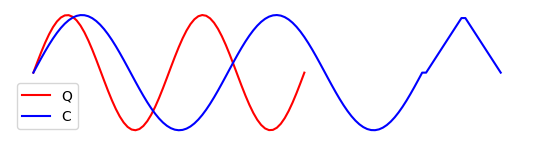

In [10]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(q, color="red", label="Q")
plt.plot(c, color="blue", label="C")
# plt.title('C vs. Q')
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.axis("off")
# plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [11]:
c_prefix = c[:100]
c_prefix_scaled = nearest_neighbor_interpolation(c_prefix, len(q))

In [12]:
len(c_prefix_scaled)

70

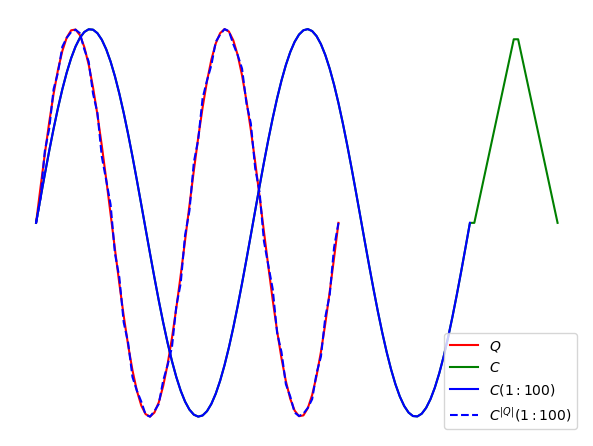

In [13]:
plt.plot(q, color="red", label="$Q$")
plt.plot(c, color="green", label="$C$")
plt.plot(c_prefix, color="blue", label="$C(1:100)$")
plt.plot(c_prefix_scaled, linestyle="--", color="blue", label="$C^{|Q|}(1:100)$")
# plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.axis("off")
plt.show()

Simply performing dtw on Q and C returns a bad result.

As shown in the above graph, Q and scaled C(1:100) have a good match.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets

Best match index: 0, Label: 1
Distance: 0.0000


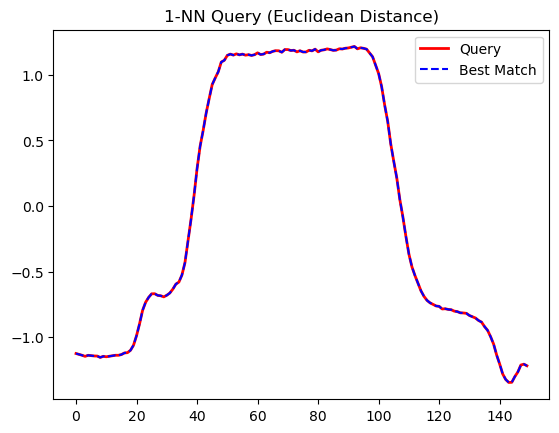

In [15]:
# Import dataset


# Load dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")
X_train = X_train.squeeze()

# Squeeze to 2D (n_samples, time_length)(univariate)
X_train = X_train.squeeze()
X_test = X_test.squeeze()

query_ts = X_test[0]


# Compute Euclidean distances to all training samples
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


distances = np.array([euclidean_distance(query_ts, x) for x in X_test])

# Find best match
best_idx = np.argmin(distances)
best_match = X_test[best_idx]

print(f"Best match index: {best_idx}, Label: {y_test[best_idx]}")
print(f"Distance: {distances[best_idx]:.4f}")

# Plot
plt.plot(query_ts, label="Query", linewidth=2, color="red")
plt.plot(best_match, label="Best Match", linestyle="--", color="blue")
plt.legend()
plt.title("1-NN Query (Euclidean Distance)")
plt.show()

In [16]:
test1 = X_test[y_test == 1][0]
test2 = X_test[y_test == 1][1]
test3 = X_test[y_test == 2][0]
test4 = X_test[y_test == 2][1]

In [17]:
len(test1)

150

In [18]:
X_test[y_test == 1]

array([[-1.1250133 , -1.1313383 , -1.1382884 , ..., -1.2127167 ,
        -1.2061778 , -1.2184217 ],
       [-1.0045865 , -0.99984343, -0.99524996, ..., -1.0449158 ,
        -1.0442265 , -1.0432617 ],
       [-0.74262544, -0.74377019, -0.74390038, ..., -0.68102951,
        -0.67051942, -0.6574027 ],
       ...,
       [-0.60274115, -0.60272758, -0.60236665, ..., -0.65724401,
        -0.65921435, -0.65908163],
       [-0.72815261, -0.73024243, -0.73356024, ..., -0.68747605,
        -0.68644801, -0.69018314],
       [-1.4272055 , -1.4083032 , -1.3471178 , ..., -1.1034614 ,
        -1.1531193 , -1.222043  ]], shape=(76, 150))

# ED

In [19]:
dist = 0
l = min(len(a1), len(b1))  # The original ed.distance can handle different lengths.
for i in range(0, l):
    dist += (a1[i] - b1[i]) ** 2
print("Distance: ", np.sqrt(dist))

Distance:  2.3275702573015664


In [20]:
%%time
distance = dtai_dtw.distance(a1, b1, window=4)
print(f"Distance: {distance}")

Distance: 0.9681751552406113
CPU times: user 286 μs, sys: 42 μs, total: 328 μs
Wall time: 300 μs


In [21]:
path = dtai_dtw.warping_path(a1, b1, window=4)

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

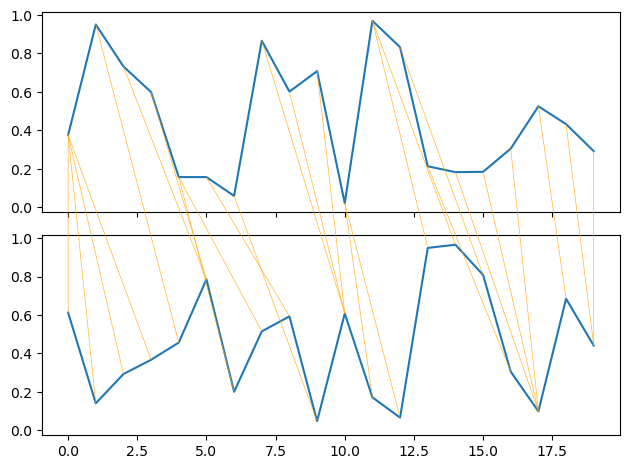

In [22]:
dtai_dtw_visualisation.plot_warping(a1, b1, path)

Test ED and DTW implementations in dtaidistance

In [23]:
# Test whether the local function is ED
dist = 0
for i in range(0, len(path)):
    dist += (a1[path[i][0]] - b1[path[i][1]]) ** 2
print("Distance: ", np.sqrt(dist))

Distance:  0.9681751552406113


In [24]:
from dtaidistance import ed as dtaidistance_ed
from dtaidistance import dtw, dtw_visualisation

In [25]:
def dtai_ed(a, b, l=1, r=0.1):
    if len(a) != len(b):
        raise ValueError("a and b must have the same length")
    # https://dtaidistance.readthedocs.io/en/latest/usage/ed.html
    return dtaidistance_ed.distance(a, b)


def dtai_dtw(a, b, l=1, r=0.1):
    if isinstance(r, float):
        # print("r is a float.")
        minlen = min(len(a), len(b))
        window = int(minlen * r)
    elif isinstance(r, int):
        # Do something when r is an int
        # print("r is an integer.")
        window = r
    else:
        raise ValueError("r must be either an integer or a float.")
    return dtw.distance(a, b, window=window)

In [26]:
# Use the self wrapped version
print(dtai_ed(a1, b1), dtai_dtw(a1, b1, _, 4))

2.3275702573015664 0.9681751552406113


In [27]:
# Use the self wrapped version
print(dtai_ed(a, b), dtai_dtw(a, b, _, 4))

6.891542596155169 1.0917139872237465


In [30]:
dist = dtai_ed.distance(np.array(a), np.array(b))
print(dist)
dist = aeon_euclidean_distance(np.array(a), np.array(b))
print(dist)
dist = ksfdtw_ed(a, b)
print(dist, math.sqrt(dist))
t_dtai_ed_distance = timeit.timeit(
    lambda: dtai_ed.distance(np.array(a), np.array(b)),
    number=100000,
)
t_aeon_dtw_distance = timeit.timeit(
    lambda: aeon_dtw_distance(np.array(a), np.array(b)),
    number=100000,
)
t_ksfdtw_ed_distance = timeit.timeit(
    lambda: ksfdtw_ed(np.array(a), np.array(b)),
    number=100000,
)
t_dtai_ed_distance, t_aeon_dtw_distance, t_ksfdtw_ed_distance

6.891542596155169
6.891542596155169
47.49335935462113 6.891542596155169


(1.9383332498837262, 4.964868291979656, 0.06781325000338256)

(Slow) aeon, dtai, ksfdtw (Fast)

# DTW

In [31]:
import numpy as np
from aeon.distances import adtw_distance

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
adtw_distance(x, y)  # 1D series

783.0

In [32]:
dtai_dtw.distance_fast(array.array("d", a), array.array("d", b), use_pruning=True)

1.0917139872237465

In [33]:
dtai_dtw.distance(a, b)

1.0917139872237465

In [34]:
(dist := aeon_dtw_distance(np.array(a), np.array(b)), math.sqrt(dist))

(1.1918394298999704, 1.0917139872237465)

In [35]:
(dist := sktime_dtw_distance(np.array(a), np.array(b)), math.sqrt(dist))

(1.1918394298999704, 1.0917139872237465)

In [36]:
pyts_dtw(a, b)

1.0917139872237465

In [37]:
tslearn_dtw(a, b)

1.0917139872237465

In [38]:
t_aeon_dtw_distance = timeit.timeit(
    lambda: aeon_dtw_distance(np.array(a), np.array(b)),
    number=1000,
)
t_sktime_dtw_distance = timeit.timeit(
    lambda: sktime_dtw_distance(np.array(a), np.array(b)),
    number=1000,
)
t_dtai_dtw_distance = timeit.timeit(
    lambda: dtai_dtw.distance(array.array("d", a), array.array("d", b)),
    number=1000,
)
t_dtai_dtw_distance_fast = timeit.timeit(
    lambda: dtai_dtw.distance_fast(
        array.array("d", a), array.array("d", b), use_pruning=True
    ),
    number=1000,
)
t_pyts_dtw_distance = timeit.timeit(
    lambda: pyts_dtw(a, b),
    number=1000,
)
t_tslearn_dtw_distance = timeit.timeit(
    lambda: tslearn_dtw(a, b),
    number=1000,
)
print(
    t_aeon_dtw_distance,
    t_sktime_dtw_distance,
    t_dtai_dtw_distance,
    t_dtai_dtw_distance_fast,
    t_pyts_dtw_distance,
    t_tslearn_dtw_distance,
)

0.07694533397443593 3.267196417087689 5.51126587507315 0.0732152909040451 0.1178619998972863 0.0931685830000788


In [13]:
aeon_dtw_distance(np.array(a), np.array(b), window=0.2)

3.0

(Slow) sktime, dtai (normal), pyts, tslearn, dtai (C), aeon (Fast)

## Sakoe-Chiba band

In [12]:
distance, paths = dtai_dtw.warping_paths_fast(
    np.array(a, dtype=np.double),
    np.array(b, dtype=np.double),
    # window=3+1
)
best_path = dtai_dtw.best_path(paths)
print(distance)
print(len(a), len(b))
print(acum_mat)
print(best_path)

1.7320508075688772
9 9
[[0.                inf        inf        inf        inf        inf
         inf        inf        inf        inf        inf        inf
         inf        inf        inf        inf        inf        inf
         inf        inf        inf]
 [       inf 0.23731278 0.33401212 0.34402487 0.34412206 0.35364829
  0.54193072 0.56944459 0.58632896 0.62550054 0.70632413 0.74376407
  0.77123765 0.83101784 1.01017984 1.17040718 1.24823278 1.25018989
  1.28048063 1.31739908 1.31903197]
 [       inf 0.41369604 0.84521948 0.73842948 0.67810096 0.60257199
  0.39047414 0.84648209 0.71748298 0.68713925 1.09951995 0.78527642
  1.07790617 1.17439599 0.83101986 0.83115374 0.84325006 1.0623166
  1.36242341 1.30791549 1.40403571]
 [       inf 0.43078798 0.72263459 0.84597172 0.77039454 0.66274205
  0.39407916 0.66017786 0.69516474 0.70117241 0.97063396 0.79507649
  0.96535352 1.17333691 0.85885736 0.86323853 0.83465803 0.93771415
  1.13210954 1.13311655 1.17009596]
 [       inf 0.430

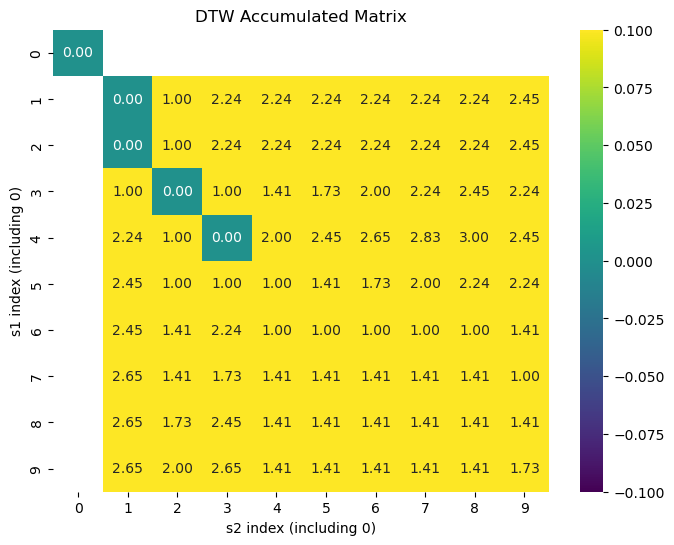

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(paths, annot=True, fmt=".2f", cmap="viridis")
plt.title("DTW Accumulated Matrix")
plt.xlabel("s2 index (including 0)")
plt.ylabel("s1 index (including 0)")
plt.show()

(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

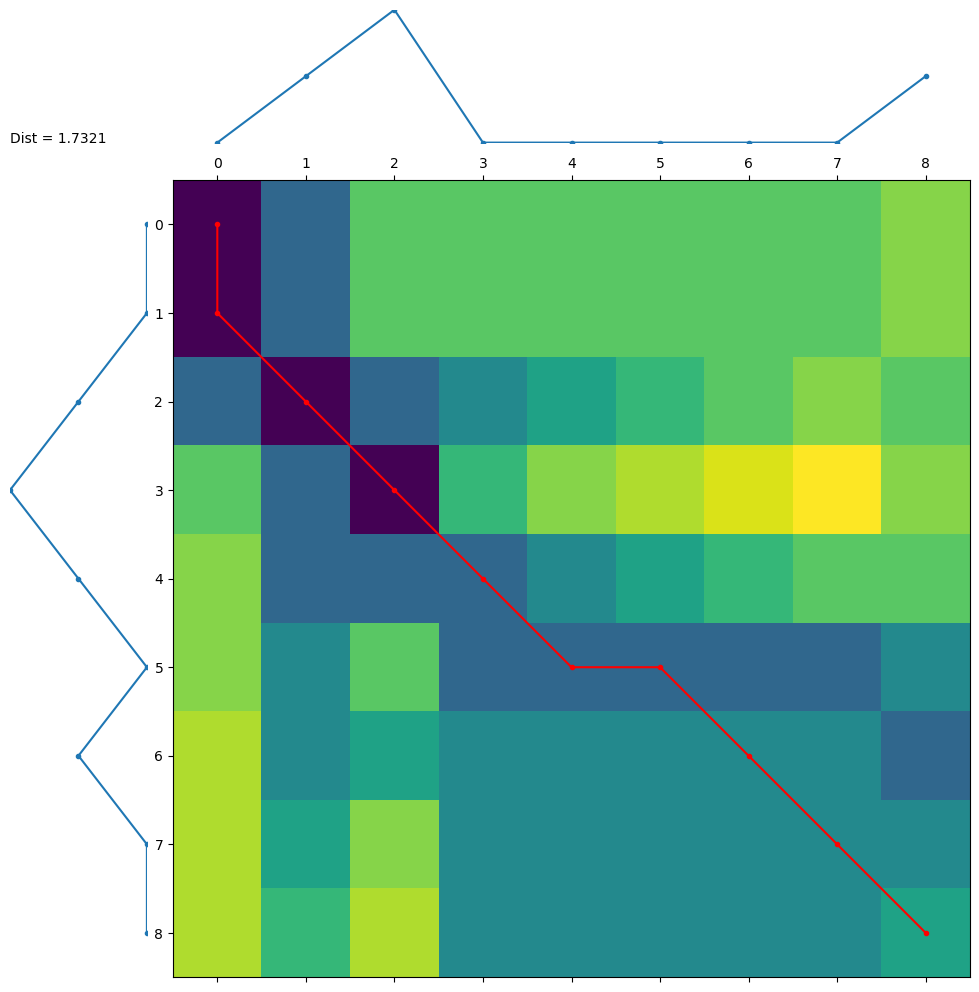

In [16]:
dtai_dtw_visualisation.plot_warpingpaths(
    np.array(a, dtype=np.double), np.array(b, dtype=np.double), paths, best_path
)

In [18]:
dist, mat = pyts_dtw(
    a, b, method="sakoechiba", options={"window_size": 1}, return_accumulated=True
)
dist, mat

(1.7320508075688772,
 array([[ 0.,  1., inf, inf, inf, inf, inf, inf, inf],
        [ 0.,  1.,  5., inf, inf, inf, inf, inf, inf],
        [inf,  0.,  1.,  2., inf, inf, inf, inf, inf],
        [inf, inf,  0.,  4.,  6., inf, inf, inf, inf],
        [inf, inf, inf,  1.,  2.,  3., inf, inf, inf],
        [inf, inf, inf, inf,  1.,  1.,  1., inf, inf],
        [inf, inf, inf, inf, inf,  2.,  2.,  2., inf],
        [inf, inf, inf, inf, inf, inf,  2.,  2.,  3.],
        [inf, inf, inf, inf, inf, inf, inf,  2.,  3.]]))

In [19]:
tslearn_dtw(a, b, global_constraint="sakoe_chiba", sakoe_chiba_radius=2)

1.7320508075688772

In [20]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
aeon_dtw_distance(x, y)  # 1D series

768.0

# US, USDTW

In [ ]:
aeon_euclidean_distance(q, c_prefix_scaled)

10.750017785167758

Test for USDTW. It select the most similar prefix $C(0:k)$ and compare it with $Q$.

In [ ]:
l = 2  # scaling_factor
L = min(np.ceil(l * len(q)), len(c))

In [ ]:
best_so_far, best_k = ksfdtw_usdtw(q, c, l, L, 0.1, "ed")
best_so_far, best_k, best_k / m  # best_k/m: best scaling factor
# k is the length of the prefix of C
# In this case, The prefix of C is longer than Q, about 1.42 times of the length of Q.

(26.180324399082302, 100, 1.4285714285714286)

# PSDTW

# Other Distance Measures

In [ ]:
from aeon.distances import get_distance_function as aeon_get_distance_function
from aeon.distances import distance as aeon_distance
import numpy as np

x = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
y = np.array([[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]])
dtw_dist_func = aeon_get_distance_function("dtw")
dtw_dist_func(x, y, window=0.2)

874.0

In [ ]:
aeon_distance(x, y, method="wdtw")

356.5017799592854

In [ ]:
import numpy as np
from aeon.distances import sbd_distance

x = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
y = np.array([[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]])
dist = sbd_distance(x, y)
dist

2.220446049250313e-16

In [ ]:
x

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

# References

In [ ]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-08-24 22:39:32.173368

